<h2>Loading the data</h2>

In [1]:
import numpy as np
import pandas as pd
from IPython.display import SVG
import os
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import catboost
from catboost import *
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import ensemble
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

Load all the dataframes

In [2]:
data_dir = '../Data'
dataframes = {}

for filename in os.listdir(data_dir):
    if filename.endswith('.csv'):
        dataframe_name = filename[:-4]

        file_path = os.path.join(data_dir, filename)
        
        dataframe = pd.read_csv(file_path)

        dataframes[dataframe_name] = dataframe

/var/folders/y5/wrdrrgbd2zvfbnq8j5r4mrqm0000gn/T/ipykernel_98674/639029313.py:10: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv(file_path)


The dataframes are

In [3]:
print(list(dataframes.keys()))

['game_lineups', 'competitions', 'appearances', 'player_valuations', 'game_events', 'players', 'games', 'club_games', 'clubs']


The diagram of the dataset structure

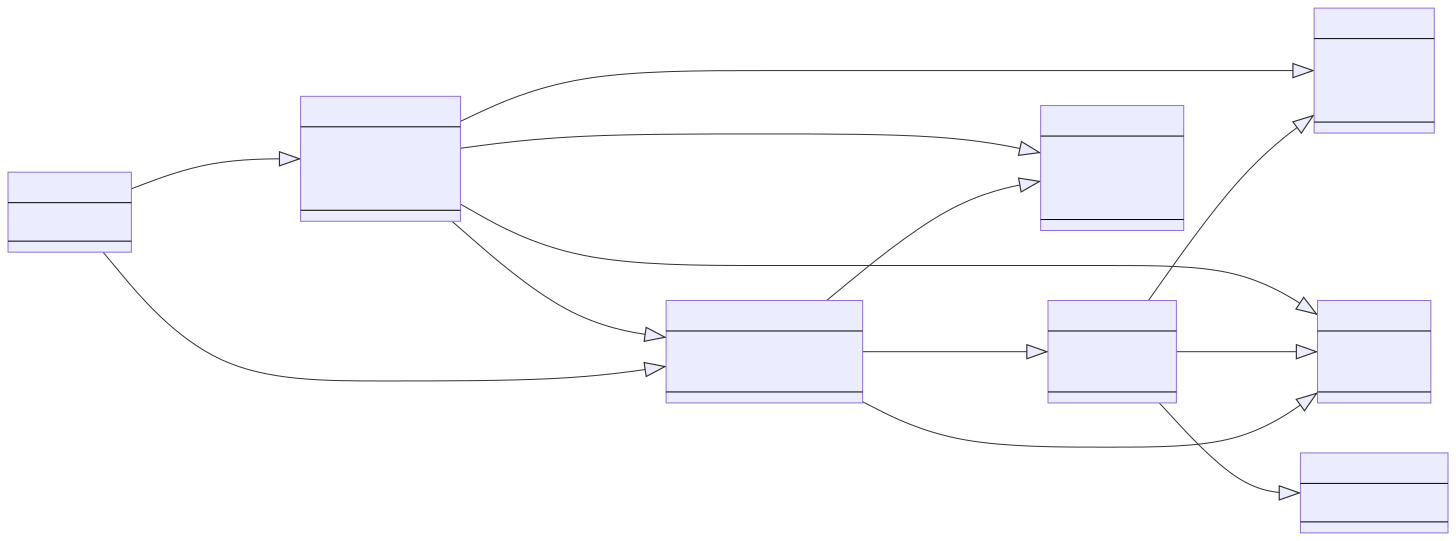

In [4]:
SVG(filename='../Other/diagram.svg')

<h2>What is important?</h2>

We would like to learn player evaluation. Do do that, we will create an extended 'players' dataframe that would contain gathered and engineered features. Most basic features that should be important are:
<br>
1. number of goals
2. number of assists
2. number of games
3. age
4. height
5. minutes played
6. position
7. club
8. league
9. game attendance

However, first we will envestigate the player features that are already present in the 'players' table. 

<h2>Filtering</h2>

Let's caclculate the percentage of missing vaues for every feature of each dataframe

In [5]:
for df_name, dataframe in dataframes.items():
    print(f"DataFrame: {df_name}")
    nan_percentage = dataframe.isna().mean() * 100
    for feature, percentage in nan_percentage.items():
        if percentage >= 10:
            print(f"Feature '{feature}' has {percentage}% NaN values")

DataFrame: game_lineups
DataFrame: competitions
Feature 'country_name' has 16.27906976744186% NaN values
Feature 'domestic_league_code' has 16.27906976744186% NaN values
DataFrame: appearances
DataFrame: player_valuations
DataFrame: game_events
Feature 'description' has 48.95900690999034% NaN values
Feature 'player_in_id' has 37.10067476070208% NaN values
Feature 'player_assist_id' has 95.07123118455735% NaN values
DataFrame: players
Feature 'contract_expiration_date' has 37.554098360655736% NaN values
Feature 'agent_name' has 50.44262295081967% NaN values
DataFrame: games
Feature 'home_club_position' has 29.706830621579066% NaN values
Feature 'away_club_position' has 29.706830621579066% NaN values
Feature 'attendance' has 14.466521706530704% NaN values
Feature 'home_club_name' has 17.092299617605157% NaN values
Feature 'away_club_name' has 15.240308915048361% NaN values
DataFrame: club_games
Feature 'own_position' has 29.706830621579066% NaN values
Feature 'opponent_position' has 29.7

First, let's drop the completely missing values

In [6]:
clubs_df = dataframes['clubs']

clubs_df = clubs_df.drop(columns=['total_market_value', 'coach_name'], axis=1)

The 'player_in_id' feature of a game_events table is about substitutions. For example, it is quite important if we want to calculate the time that player spent playing. However, this feature is not applicable for other event types, so this amount of missing values is deceiving. Simillar logic applies to 'player_assist_id'

In [7]:
game_events_df = dataframes['game_events']
game_events_df.head()

,game_event_id,date,game_id,minute,type,club_id,player_id,description,player_in_id,player_assist_id
0,2f41da30c471492e7d4a984951671677,2012-08-05,2211607,77,Cards,610,4425,"1. Yellow card , Mass confrontation",NaN,NaN
1,a72f7186d132775f234d3e2f7bc0ed5b,2012-08-05,2211607,77,Cards,383,33210,"1. Yellow card , Mass confrontation",NaN,NaN
2,b2d721eaed4692a5c59a92323689ef18,2012-08-05,2211607,3,Goals,383,36500,", Header, 1. Tournament Goal Assist: , Corner,...",NaN,56416.0
3,aef768899cedac0c9a650980219075a2,2012-08-05,2211607,53,Goals,383,36500,", Right-footed shot, 2. Tournament Goal Assist...",NaN,146258.0
4,5d6d9533023057b6619ecd145a038bbe,2012-08-05,2211607,74,Substitutions,383,36500,", Not reported",49499.0,NaN


Features 'agent_name' should be important but have a lot of missing values. Certainly, we do not want to drop the 'agent_name' NaN rows, because we are especially interested in estimating price of players withput knowing their agent. Therefore, we might want to completely ignore the 'agent_name' feature. Let's see if the distribution of mean_price by agent is very uneven:

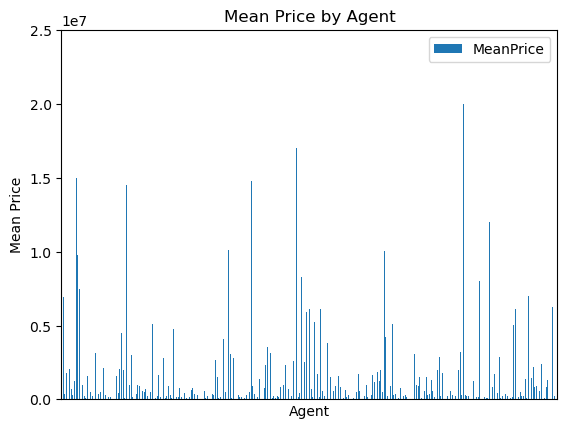

In [8]:
players_df = dataframes['players']

by_agent = players_df.groupby('agent_name').agg(MeanPrice=('market_value_in_eur', 'mean'))

by_agent.plot(kind='bar')
plt.xlabel('Agent')
plt.ylabel('Mean Price')
plt.title('Mean Price by Agent')
plt.xticks([])
plt.ylim([0, 25e6])
plt.show()

It indeed looks like the agent feature is very biased. We will completely ignore it. 

In [9]:
players_df = players_df.drop('agent_name', axis=1)

<h2>Analysing the 'players' dataframe</h2>

In [10]:
players_df.sample(2)

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,...,position,foot,height_in_cm,contract_expiration_date,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur
3480,41100,Steven,De Petter,Steven De Petter,2019,475,steven-de-petter,Belgium,Aalst,Belgium,...,Midfield,right,181.0,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/steven-de-pett...,BE1,Koninklijke Sint-Truidense Voetbalvereniging,200000.0,1000000.0
15739,271611,Wieger,Sietsma,Wieger Sietsma,2016,306,wieger-sietsma,Netherlands,Groningen,Netherlands,...,Goalkeeper,NaN,195.0,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/wieger-sietsma...,NL1,Sportclub Heerenveen,100000.0,100000.0


Let's drop the columns that will not be used: ['first_name', 'last_name', 'name', 'player_code', 'city_of_birth', 'country_of_birth', 'image_url', 'url']

In [11]:
players_df = players_df.drop(columns=['first_name', 'last_name', 'name', 'player_code', 
                                      'current_club_name', 'image_url', 'url'], axis=1)

In [12]:
players_df.sample(2)

,player_id,last_season,current_club_id,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,contract_expiration_date,current_club_domestic_competition_id,market_value_in_eur,highest_market_value_in_eur
14752,249619,2012,9007,NaN,NaN,Ukraine,1992-08-13,Right Midfield,Midfield,NaN,180.0,NaN,UKR1,100000.0,100000.0
28133,724529,2023,54189,Ireland,Dublin,Ireland,2003-11-14,Left-Back,Defender,left,177.0,2024-06-30 00:00:00,BE1,800000.0,1500000.0


The meaning of 'last_season' feature is unclear. There are entries in the dataframe with 'contract_expiration_date' signifiacntly past last season year. It might be wise to consider only the last few seasons, also because of the probable season-mean_price relation and footbal money growth.

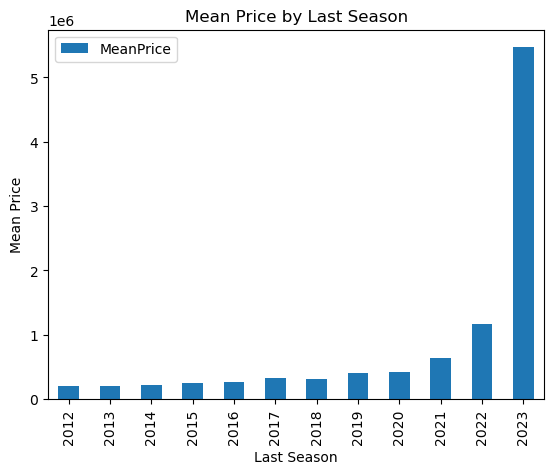

In [13]:
by_season = players_df.groupby('last_season').agg(MeanPrice=('market_value_in_eur', 'mean'))

by_season.plot(kind='bar')
plt.xlabel('Last Season')
plt.ylabel('Mean Price')
plt.title('Mean Price by Last Season')
plt.show()

Well, that looks crazy. Let's see if we have enough data to maybe only use the 2023 entries.

In [14]:
condition = players_df['last_season'] >= 2023

len(players_df[condition]) / len(players_df)

0.2142622950819672

Well, it migh not be a bad idea. Let's only keep year 2023.

In [15]:
players_df = players_df[condition]
players_df = players_df.drop('last_season', axis=1)

Now, let's tranform the 'date_of_birth' feature into age and 'contract_expiration_date' into 'months_to_contract_end'.

In [16]:
players_df['contract_expiration_date'] = pd.to_datetime(players_df['contract_expiration_date'])
now = pd.Timestamp(datetime.now().date())
non_na_expiration_dates = players_df['contract_expiration_date'].dropna()
months_to_contract_end = (non_na_expiration_dates - now).dt.days / 30.44
players_df['months_to_contract_end'] = months_to_contract_end.reindex(players_df.index)
players_df['months_to_contract_end'] = players_df['months_to_contract_end'].round()
players_df = players_df.drop('contract_expiration_date', axis=1)

players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth'])
now = datetime.now()
players_df['age'] = (now - players_df['date_of_birth']).apply(lambda x: x.days) / 365.25
players_df['age'] = players_df['age'].round() 
players_df = players_df.drop('date_of_birth', axis=1)

Separate categorcial and numerical features:

In [17]:
players_df.sample(2)

,player_id,current_club_id,country_of_birth,city_of_birth,country_of_citizenship,sub_position,position,foot,height_in_cm,current_club_domestic_competition_id,market_value_in_eur,highest_market_value_in_eur,months_to_contract_end,age
26159,616369,681,Spain,Donostia-San Sebastián,Spain,Left Winger,Attack,right,175.0,ES1,20000000.0,20000000.0,76.0,22.0
23016,477758,985,England,London,England,Right-Back,Defender,right,183.0,GB1,20000000.0,40000000.0,16.0,26.0


In [18]:
categorical = ['current_club_id', 'country_of_citizenship', 'sub_position', 
               'position', 'foot', 'current_club_domestic_competition_id', 
              'city_of_birth', 'country_of_birth']

numerical = ['height_in_cm', 'age', 'months_to_contract_end'] 

all_features = categorical + numerical

Let's drop NaN's and try training a simple model.

In [19]:
players_df = players_df.dropna()

X = players_df.drop(columns=['market_value_in_eur', 'highest_market_value_in_eur', 'player_id'], axis=1)
y = players_df['market_value_in_eur']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=12)

model = CatBoostRegressor(
    iterations=8000,
    learning_rate=0.001,
    cat_features=categorical, 
    eval_metric = 'MAE'
) 

model.fit(
    X_train, y_train,
    cat_features=categorical,
    eval_set=(X_val, y_val),
    logging_level='Silent',
    plot=True
)

print(f'R2 accuracy score: {round(model.score(X_val, y_val), 2)} \n')

print('Feature importances: \n')
feature_importances = model.get_feature_importance(Pool(X, label=y, cat_features=categorical))
for i in range(len(feature_importances)):
    print(f'{all_features[i]} : {round(feature_importances[i], 2)}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

R2 accuracy score: 0.5 

Feature importances: 

current_club_id : 30.26
country_of_citizenship : 3.79
sub_position : 2.53
position : 2.73
foot : 3.84
current_club_domestic_competition_id : 7.04
city_of_birth : 1.61
country_of_birth : 0.59
height_in_cm : 17.3
age : 22.11
months_to_contract_end : 8.2


Well, that is quite a horrible mean_loss. Rougly 80% of the mean target value. Let's engineer features from other dataframes.

<h2>Feature engineering</h2>

Note from the 'feature importances' above that 'position' feature had surprisingly weight for model predictions. Let's see whether the mean_price ditribution over position is indeed close to uniform.

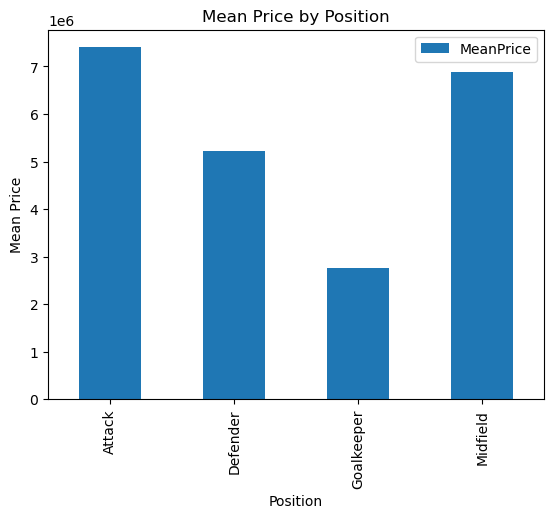

In [20]:
by_position = players_df.groupby('position').agg(MeanPrice=('market_value_in_eur', 'mean'))

by_position.plot(kind='bar')
plt.xlabel('Position')
plt.ylabel('Mean Price')
plt.title('Mean Price by Position')
plt.show()

Ok. They are indeed of the same order of magnitude. Let's investigate the apperances table.

In [21]:
games_df = dataframes['games']
appearances_df = dataframes['appearances']

appearances_df.sample(3)

,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played
1290238,3602623_241119,3602623,241119,121,2381,2022-05-06,Clinton N'Jie,RU1,0,0,0,0,64
530633,2718708_221316,2718708,221316,418,418,2016-08-21,Lucas Vázquez,ES1,0,0,0,0,24
127551,2242987_12249,2242987,12249,1049,368,2013-05-18,Éver Banega,ES1,0,0,0,1,89


Let's filter out players with last_season != 2023 and then add the group_by statistics to players_df table

In [22]:
appearances_df = appearances_df[appearances_df['player_id'].isin(players_df['player_id'])]
appearances_df['num_games'] = 1

by_player = appearances_df.groupby('player_id').sum()
by_player = by_player[['yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played', 'num_games']]

/var/folders/y5/wrdrrgbd2zvfbnq8j5r4mrqm0000gn/T/ipykernel_98674/2055968717.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appearances_df['num_games'] = 1


Let's merge that with the players dataframe

In [23]:
players_df = pd.merge(players_df, by_player, on='player_id', suffixes=('', ''))

players_df.sample(5)

,player_id,current_club_id,country_of_birth,city_of_birth,country_of_citizenship,sub_position,position,foot,height_in_cm,current_club_domestic_competition_id,market_value_in_eur,highest_market_value_in_eur,months_to_contract_end,age,yellow_cards,red_cards,goals,assists,minutes_played,num_games
2934,380350,1237,Brazil,Bom Sucesso,Brazil,Centre-Back,Defender,left,188.0,GB1,17000000.0,17000000.0,40.0,26.0,38,0,1,2,9989,139
1813,258004,281,Portugal,Amadora,Portugal,Centre-Back,Defender,right,187.0,GB1,80000000.0,80000000.0,40.0,27.0,46,0,15,10,24102,280
4259,566931,23826,Netherlands,Amsterdam,Netherlands,Right Winger,Attack,right,179.0,L1,70000000.0,70000000.0,4.0,21.0,14,0,30,21,6351,86
5119,743122,2282,Belgium,Gent,Belgium,Right-Back,Defender,right,176.0,BE1,2500000.0,2500000.0,16.0,19.0,0,0,0,3,599,16
5334,854325,172,France,Noisy-le-Grand,France,Defensive Midfield,Midfield,left,191.0,BE1,1200000.0,1200000.0,40.0,21.0,2,0,0,0,269,4


Let's try learning a model!

In [24]:
categorical = ['current_club_id', 'country_of_citizenship', 'sub_position', 
               'position', 'foot', 'current_club_domestic_competition_id',
              'city_of_birth', 'country_of_birth']

numerical = ['height_in_cm', 'age', 'months_to_contract_end', 'yellow_cards', 'red_cards',
            'goals', 'assists', 'minutes_played', 'num_games'] 

all_features = categorical + numerical

In [25]:
players_df = players_df.dropna()

X = players_df.drop(columns=['market_value_in_eur', 'highest_market_value_in_eur', 'player_id'], axis=1)
y = players_df['market_value_in_eur']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=12)

model = CatBoostRegressor(
    iterations=8000,
    learning_rate=0.01,
    cat_features=categorical, 
    eval_metric = 'MAE'
) 

model.fit(
    X_train, y_train,
    cat_features=categorical,
    eval_set=(X_val, y_val),
    logging_level='Silent',
    plot=True
)

print(f'R2 accuracy score: {round(model.score(X_val, y_val), 2)} \n')

print('Feature importances: \n')
feature_importances = model.get_feature_importance(Pool(X, label=y, cat_features=categorical))
for i in range(len(feature_importances)):
    print(f'{all_features[i]} : {round(feature_importances[i], 2)}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

R2 accuracy score: 0.75 

Feature importances: 

current_club_id : 12.58
country_of_citizenship : 2.26
sub_position : 1.08
position : 1.84
foot : 1.27
current_club_domestic_competition_id : 0.92
city_of_birth : 1.06
country_of_birth : 1.17
height_in_cm : 11.47
age : 10.63
months_to_contract_end : 19.63
yellow_cards : 2.97
red_cards : 0.32
goals : 9.2
assists : 8.96
minutes_played : 9.19
num_games : 5.46


Certainly an improvement but still really bad. These new features are very attack-oriented. We should try engineering something that measures the defensive qualities. But before that, let's try training and evaluating only for players with Attack value of feature 'position' and see if the performance will improve. 

In [26]:
condition = players_df['position'] == 'Attack'
attackers_df = players_df[condition]

X = attackers_df.drop(columns=['market_value_in_eur', 'highest_market_value_in_eur', 'player_id'], axis=1)
y = attackers_df['market_value_in_eur']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=12)

model = CatBoostRegressor(
    iterations=8000,
    learning_rate=0.001,
    cat_features=categorical, 
    eval_metric = 'MAE'
) 

model.fit(
    X_train, y_train,
    cat_features=categorical,
    eval_set=(X_val, y_val),
    logging_level='Silent',
    plot=False
)

print(f'R2 accuracy score: {round(model.score(X_val, y_val), 2)} \n')

print('Feature importances: \n')
feature_importances = model.get_feature_importance(Pool(X, label=y, cat_features=categorical))
for i in range(len(feature_importances)):
    print(f'{all_features[i]} : {round(feature_importances[i], 2)}')

R2 accuracy score: 0.7 

Feature importances: 

current_club_id : 5.97
country_of_citizenship : 1.7
sub_position : 0.35
position : 1.88
foot : 0.96
current_club_domestic_competition_id : 0.0
city_of_birth : 1.27
country_of_birth : 0.31
height_in_cm : 15.49
age : 9.08
months_to_contract_end : 24.42
yellow_cards : 1.69
red_cards : 0.38
goals : 16.33
assists : 14.4
minutes_played : 3.27
num_games : 2.49


Surpisingly, the performance has dropped. Also, 'assists' feature got more weight that 'goals'. Which is either a nice football insight or an indicator of weak learning of our model. Another detail worth mentioning is the importance of 'months_to_contract_end' feature. A longer contract indicates the value of a player in time. Let's investigate the game_events table and try collecting valuable info.

In [27]:
game_events_df = game_events_df[game_events_df['player_id'].isin(players_df['player_id'])]
print(game_events_df['type'].unique())
game_events_df.sample(5)

['Cards' 'Goals' 'Substitutions' 'Shootout']


,game_event_id,date,game_id,minute,type,club_id,player_id,description,player_in_id,player_assist_id
573697,f673fe05a237d96e8f16ab5e39324ce2,2022-09-18,3851092,77,Substitutions,601,748939,NaN,486053.0,NaN
518830,beee492c65d89e5f364497fca877edb7,2022-02-05,3610326,77,Substitutions,368,182877,NaN,223725.0,NaN
581586,d79e1305cffbfaab4b266174fb15f930,2023-01-04,3860324,46,Substitutions,3205,269393,NaN,257785.0,NaN
568348,90717b6294bc2d0cfd43d3d4ab76c3d5,2022-08-22,3844600,55,Substitutions,12321,461617,NaN,131506.0,NaN
400964,708ebe66c14c8cd54ffc09bdad2e13d3,2020-03-01,3219202,90,Substitutions,148,192765,NaN,552655.0,NaN


That is not very rich. Unfortunately, there is no free-kick statistic. Possibilities are: count percentage of games a given player was substituted during his games; count percentage of shootouts that were scored by a given player. Maybe, there is more info in the 'description' column. Hopefully, it is structured.

In [28]:
descriptions = game_events_df.loc[game_events_df['type'] == 'Goals']['description']
print(descriptions.unique(), len(descriptions.unique()))

[', Header, 1. Tournament Goal Assist: , Corner, 1. Tournament Assist'
 ', Left-footed shot, 1. Tournament Goal Assist: , Pass, 1. Tournament Assist'
 ', Left-footed shot, 2. Tournament Goal Assist: , Pass, 1. Tournament Assist'
 ...
 ', Right-footed shot, 10. Goal of the Season Assist: , Pass, 8. Assist of the Season'
 ', Penalty, 6. Tournament Goal Assist: Handball by'
 ', Header, 1. Tournament Goal Assist: , Shot on goal, 1. Tournament Assist'] 2456


It is not obvious how to make use of that in a clever way. For now, let's stick to more basic features. 

In [29]:
subs_by_player = game_events_df.groupby('player_id')['type'].apply(lambda x: (x == 'Substitutions').sum()).reset_index(name='substitutions')
players_df = pd.merge(players_df, subs_by_player, how='outer', on='player_id', suffixes=('', ''))

players_df['substitutions'].fillna(0, inplace=True)
players_df['percentage_of_substitutions'] = 100 * players_df['substitutions'] / players_df['num_games']
players_df = players_df.drop('substitutions', axis=1)

In [30]:
shootouts_by_player = game_events_df.groupby('player_id')['type'].apply(lambda x: (x == 'Shootout').sum()).reset_index(name='shootouts')
shootouts_by_player.describe()

,player_id,shootouts
count,5.260000e+03,5260.000000
mean,3.854204e+05,0.070152
std,2.274551e+05,0.282975
min,3.333000e+03,0.000000
25%,2.041610e+05,0.000000
50%,3.562965e+05,0.000000
75%,5.400580e+05,0.000000
max,1.176345e+06,4.000000


That is too little data if max shootouts by player is 4. Let's just ignore this feature. Calculating average game attendance by player might be a good idea. 

In [31]:
merged_df = pd.merge(appearances_df, games_df, on='game_id')
average_attendance_by_player = merged_df.groupby('player_id')['attendance'].mean().reset_index(name='average_attendance')
overall_mean_attendance = average_attendance_by_player['average_attendance'].mean()
average_attendance_by_player['average_attendance'].fillna(overall_mean_attendance, inplace=True)
players_df = pd.merge(players_df, average_attendance_by_player, how='outer', on='player_id', suffixes=('', ''))

Another straightforward feature is percentage of won games.

In [33]:
club_games_df = dataframes['club_games']

In [34]:
merged_df = pd.merge(appearances_df, club_games_df[['game_id', 'club_id', 'is_win']], 
                     left_on=['game_id', 'player_club_id'], 
                     right_on=['game_id', 'club_id'])

player_win_percentage = merged_df.groupby('player_id')['is_win'].mean().reset_index(name='win_percentage')
player_win_percentage['win_percentage'] *= 100
players_df = pd.merge(players_df, player_win_percentage, how='outer', on='player_id', suffixes=('', ''))

And, also, the 'squad_size' and 'national_team_players' features of a player's current club. That should teach the model the club quality parameter

In [35]:
merged_df = pd.merge(appearances_df, clubs_df[['club_id', 'squad_size', 'national_team_players']], 
                     left_on=['player_club_id'], 
                     right_on=['club_id'])
player_squad_size = merged_df.groupby('player_id')['squad_size'].mean().reset_index(name='squad_size')
player_national_team_coplayers = merged_df.groupby('player_id')['national_team_players'].mean().reset_index(name='national_team_coplayers')
players_df = pd.merge(players_df, player_squad_size, how='outer', on='player_id', suffixes=('', ''))
players_df = pd.merge(players_df, player_national_team_coplayers, how='outer', on='player_id', suffixes=('', ''))

Let's try learning a new model!

In [36]:
categorical = ['current_club_id', 'country_of_citizenship', 'sub_position', 
               'position', 'foot', 'current_club_domestic_competition_id',
              'city_of_birth', 'country_of_birth']

numerical = ['height_in_cm', 'age', 'months_to_contract_end', 'yellow_cards', 'red_cards',
            'goals', 'assists', 'minutes_played', 'num_games', 'percentage_of_substitutions',
            'average_attendance', 'win_percentage', 'national_team_coplayers', 'squad_size'] 

all_features = categorical + numerical

After normalizing numerical data

In [37]:
scaler = StandardScaler()
players_df[numerical] = scaler.fit_transform(players_df[numerical])

In [38]:
players_df = players_df.dropna()

X = players_df.drop(columns=['market_value_in_eur', 'highest_market_value_in_eur', 'player_id'], axis=1)
y = players_df['market_value_in_eur']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=12)

model = CatBoostRegressor(
    iterations=8000,
    learning_rate=0.01,
    cat_features=categorical, 
    eval_metric = 'MAE'
) 

model.fit(
    X_train, y_train,
    cat_features=categorical,
    eval_set=(X_val, y_val),
    logging_level='Silent',
    plot=True
)

print(f'R2 accuracy score: {round(model.score(X_val, y_val), 2)} \n')

print('Feature importances: \n')
feature_importances = model.get_feature_importance(Pool(X, label=y, cat_features=categorical))
for i in range(len(feature_importances)):
    print(f'{all_features[i]} : {round(feature_importances[i], 2)}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

R2 accuracy score: 0.75 

Feature importances: 

current_club_id : 4.68
country_of_citizenship : 1.19
sub_position : 0.29
position : 0.81
foot : 0.68
current_club_domestic_competition_id : 0.57
city_of_birth : 0.4
country_of_birth : 0.47
height_in_cm : 7.5
age : 10.5
months_to_contract_end : 15.31
yellow_cards : 2.87
red_cards : 0.13
goals : 8.75
assists : 4.17
minutes_played : 7.23
num_games : 4.46
percentage_of_substitutions : 0.88
average_attendance : 11.06
win_percentage : 6.53
national_team_coplayers : 1.65
squad_size : 9.85


Unlike 'percentage_of_substitutions', features 'average_attendance' and 'win_percentage' turned out to be valuable. The model still sucks. Let's compare the ditributions of target values and model predictions.

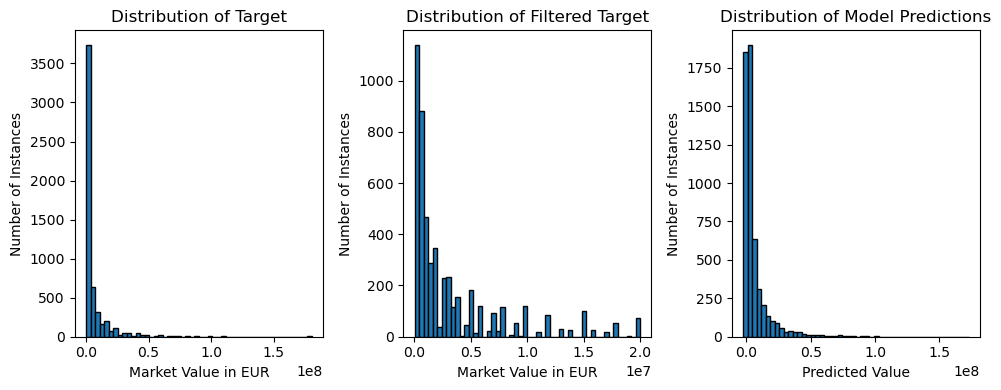

In [39]:
predictions = model.predict(X)
condition = players_df['market_value_in_eur'] <= 2e7
cheap_df = players_df[condition]

fig, axs = plt.subplots(1, 3, figsize=(10, 4))

axs[0].hist(players_df['market_value_in_eur'], bins=50, edgecolor='black')
axs[0].set_title('Distribution of Target')
axs[0].set_xlabel('Market Value in EUR')
axs[0].set_ylabel('Number of Instances')

axs[1].hist(cheap_df['market_value_in_eur'], bins=50, edgecolor='black')
axs[1].set_title('Distribution of Filtered Target')
axs[1].set_xlabel('Market Value in EUR')
axs[1].set_ylabel('Number of Instances')

axs[2].hist(predictions, bins=50, edgecolor='black')
axs[2].set_title('Distribution of Model Predictions')
axs[2].set_xlabel('Predicted Value')
axs[2].set_ylabel('Number of Instances')

plt.tight_layout() 
plt.show()

Hmm, let's try predicting the log of the target.

In [40]:
players_df['log_target'] = np.log(players_df['market_value_in_eur'])

In [44]:
X = players_df.drop(columns=['log_target', 'market_value_in_eur', 'highest_market_value_in_eur', 'player_id'], axis=1)
y = players_df['log_target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=12)

model = CatBoostRegressor(
    iterations=1000,
    depth=6,
    l2_leaf_reg=5,
    border_count=128,
    random_seed=12,
    learning_rate=0.05,
    cat_features=categorical,
    eval_metric='MAE'
)
model.fit(
    X_train, y_train,
    cat_features=categorical,
    eval_set=(X_val, y_val),
    logging_level='Silent',
    plot=True
)

print('Feature importances: \n')
feature_importances = model.get_feature_importance(Pool(X, label=y, cat_features=categorical))
for i in range(len(feature_importances)):
    print(f'{all_features[i]} : {round(feature_importances[i], 2)}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Feature importances: 

current_club_id : 8.67
country_of_citizenship : 2.18
sub_position : 0.77
position : 2.01
foot : 0.55
current_club_domestic_competition_id : 0.92
city_of_birth : 0.45
country_of_birth : 0.54
height_in_cm : 8.35
age : 8.72
months_to_contract_end : 17.45
yellow_cards : 1.42
red_cards : 0.07
goals : 3.87
assists : 2.95
minutes_played : 9.46
num_games : 8.99
percentage_of_substitutions : 1.41
average_attendance : 9.36
win_percentage : 4.42
national_team_coplayers : 1.27
squad_size : 6.16


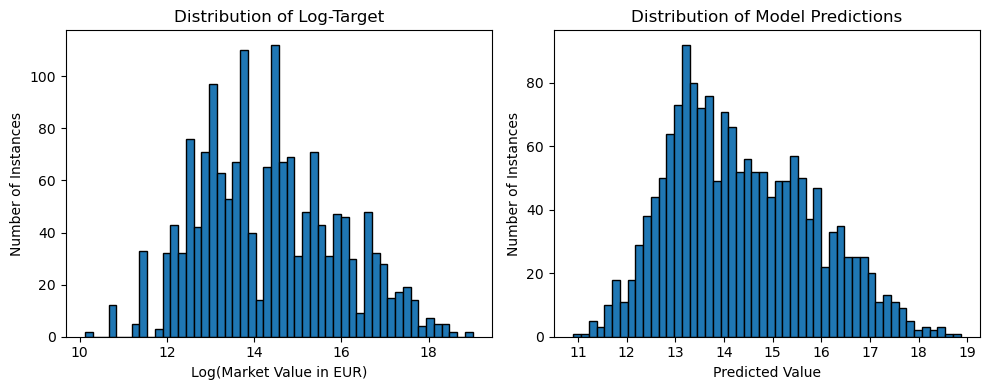

In [45]:
predictions = model.predict(X_val)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].hist(y_val, bins=50, edgecolor='black')
axs[0].set_title('Distribution of Log-Target')
axs[0].set_xlabel('Log(Market Value in EUR)')
axs[0].set_ylabel('Number of Instances')

axs[1].hist(predictions, bins=50, edgecolor='black')
axs[1].set_title('Distribution of Model Predictions')
axs[1].set_xlabel('Predicted Value')
axs[1].set_ylabel('Number of Instances')

plt.tight_layout() 
plt.show()

The model fits the distrbution of the target quite good but target ditrbution is very unsmooth and that might complicate the learning. What if we convert the log-prediction to actual prices and measure the MAE?

In [46]:
log_predictions = np.array(model.predict(X_val))  
actual_values = np.array(y_val)

predictions = np.exp(log_predictions)

mae = mean_absolute_error(actual_values, predictions)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 5254453.560293918


Awful:)

<h2>Switching task to classification</h2>

Because of the discrete nature of data, it might be a good idea to classify players inot 'price bins' instead of predicting a numerical value. It also makes sense to make these bins on log-scale. Let' label the data into 10 classes.

In [47]:
players_df['log_target'].describe()

count    5540.000000
mean       14.414656
std         1.585014
min        10.126631
25%        13.122363
50%        14.285514
75%        15.607270
max        19.008467
Name: log_target, dtype: float64

In [48]:
def determine_label(log_value):
    return int(log_value - 9) - 1

players_df['label'] = players_df['log_target'].apply(determine_label)

In [49]:
X = players_df.drop(columns=['market_value_in_eur', 'highest_market_value_in_eur', 
                             'player_id', 'log_target', 'label'], 
                            axis=1)
y = players_df['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=12)

model = CatBoostClassifier(
    iterations=1000,
    depth=6,
    l2_leaf_reg=5,
    border_count=128,
    random_seed=12,
    learning_rate=0.05,
    cat_features=categorical,
    eval_metric='Accuracy'
)
model.fit(
    X_train, y_train,
    cat_features=categorical,
    eval_set=(X_val, y_val),
    logging_level='Silent',
    plot=True
)

print('Feature importances: \n')
feature_importances = model.get_feature_importance(Pool(X, label=y, cat_features=categorical))
for i in range(len(feature_importances)):
    print(f'{all_features[i]} : {round(feature_importances[i], 2)}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Feature importances: 

current_club_id : 16.58
country_of_citizenship : 5.63
sub_position : 2.36
position : 4.5
foot : 2.59
current_club_domestic_competition_id : 2.99
city_of_birth : 2.11
country_of_birth : 0.86
height_in_cm : 9.29
age : 5.93
months_to_contract_end : 11.98
yellow_cards : 1.16
red_cards : 0.2
goals : 3.41
assists : 1.87
minutes_played : 6.89
num_games : 4.54
percentage_of_substitutions : 1.43
average_attendance : 5.67
win_percentage : 4.11
national_team_coplayers : 1.59
squad_size : 4.33


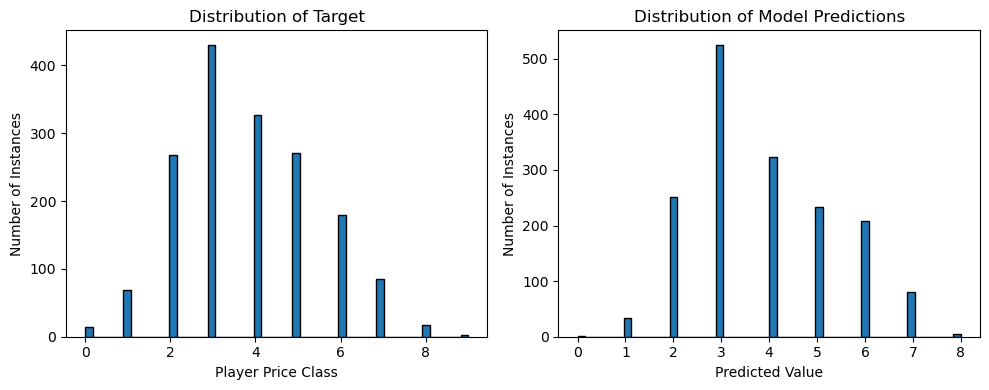

In [50]:
predictions = model.predict(X_val)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].hist(y_val, bins=50, edgecolor='black')
axs[0].set_title('Distribution of Target')
axs[0].set_xlabel('Player Price Class')
axs[0].set_ylabel('Number of Instances')

axs[1].hist(predictions, bins=50, edgecolor='black')
axs[1].set_title('Distribution of Model Predictions')
axs[1].set_xlabel('Predicted Value')
axs[1].set_ylabel('Number of Instances')

plt.tight_layout() 
plt.show()

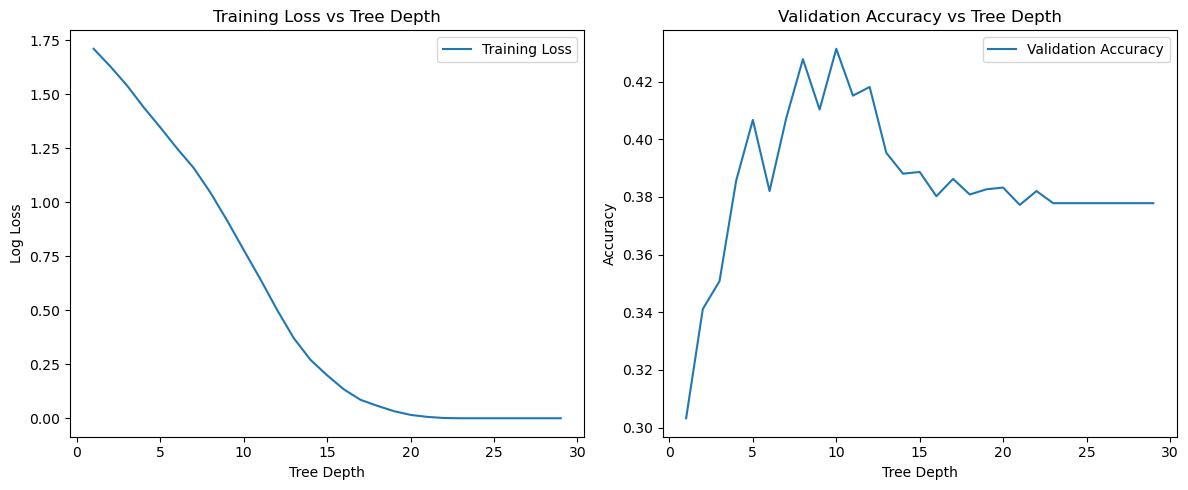

In [51]:
# Define the column transformer
column_transformer = ColumnTransformer([
    ("ohe", OneHotEncoder(handle_unknown='ignore'), categorical)
], remainder='passthrough')

# Prepare the data
X = players_df.drop(columns=['market_value_in_eur', 'highest_market_value_in_eur', 
                             'player_id', 'log_target', 'label'], axis=1)
y = players_df['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=12)

# Apply the transformations
X_train = column_transformer.fit_transform(X_train)
X_val = column_transformer.transform(X_val)

# Lists to store metrics
train_losses = []
val_accuracies = []

max_depth = 30
# Loop over a range of tree depths
for depth in range(1, max_depth):  # Example: Trying depths from 1 to 10
    model = DecisionTreeClassifier(max_depth=depth, random_state=12)
    model.fit(X_train, y_train)

    # Compute training loss and validation accuracy
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    val_accuracy = accuracy_score(y_val, model.predict(X_val))

    # Store metrics
    train_losses.append(train_loss)
    val_accuracies.append(val_accuracy)

# Plotting
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, max_depth), train_losses, label='Training Loss')
plt.xlabel('Tree Depth')
plt.ylabel('Log Loss')
plt.title('Training Loss vs Tree Depth')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, max_depth), val_accuracies, label='Validation Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Tree Depth')
plt.legend()

plt.tight_layout()
plt.show()


In [52]:
knn = KNeighborsClassifier(n_neighbors=25, weights='distance', algorithm='auto', p=1)
knn.fit(X_train, y_train)

svm = SVC(C=2, gamma=0.01)
svm.fit(X_train, y_train)

knn_predictions = knn.predict(X_val)
knn_accuracy = accuracy_score(y_val, knn_predictions)
print(f"KNN Accuracy: {knn_accuracy}")

# Evaluate SVM
svm_predictions = svm.predict(X_val)
svm_accuracy = accuracy_score(y_val, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy}")

KNN Accuracy: 0.4326113116726835
SVM Accuracy: 0.49759326113116725


In [53]:
player_valuations_df = dataframes['player_valuations']
game_lineups_df = dataframes['game_lineups']

In [54]:
player_valuations_df = player_valuations_df[player_valuations_df['player_id'].isin(players_df['player_id'])]
game_lineups_df = game_lineups_df[game_lineups_df['player_id'].isin(players_df['player_id'])]

<h2>Neural Nets</h2>

In [55]:
players_df['current_club_id'] = players_df['current_club_id'].astype('object')

In [56]:
cols = players_df.columns.tolist()
a, b = cols.index('height_in_cm'), cols.index('current_club_domestic_competition_id')
cols[b], cols[a] = cols[a], cols[b]
players_df = players_df[cols]

In [57]:
players_df['label'].describe()

count    5540.000000
mean        3.897292
std         1.622339
min         0.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         9.000000
Name: label, dtype: float64

In [58]:
def process_data(df, to_drop, target):
    y = df[target]
    dataframe = df.drop(columns=to_drop, axis=1)
    categorical_cols = [col for col in dataframe.columns if dataframe[col].dtype not in ['int64', 'float']]
    numerical_cols = [col for col in dataframe.columns if dataframe[col].dtype in ['int64', 'float64']]

    for category in categorical_cols:
        dataframe[category] = dataframe[category].astype('category').cat.codes

    categorical_data = torch.tensor(dataframe[categorical_cols].values, dtype=torch.int64)
    numerical_data = torch.tensor(dataframe[numerical_cols].values, dtype=torch.float32)
    all_data = torch.cat([numerical_data, categorical_data], dim=1)
    
    X = dataframe
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=12)
    
    X_train_num = torch.tensor(X_train[numerical_cols].values, dtype=torch.float32)
    X_train_cat = torch.tensor(X_train[categorical_cols].values, dtype=torch.int64)
    y_train = torch.tensor(y_train.values, dtype=torch.long)
    X = torch.tensor(X.values, dtype=torch.long)

    X_val_num = torch.tensor(X_val[numerical_cols].values, dtype=torch.float32)
    X_val_cat = torch.tensor(X_val[categorical_cols].values, dtype=torch.int64)
    y_val = torch.tensor(y_val.values, dtype=torch.long)
    y = torch.tensor(y.values, dtype=torch.long)
    
    return (X, X_train, X_train_num, X_train_cat, y_train), (y, X_val, X_val_num, X_val_cat, y_val)

(X, X_train, X_train_num, X_train_cat, y_train), (y, X_val, X_val_num, X_val_cat, y_val) = process_data(players_df, 
                            ['market_value_in_eur', 'highest_market_value_in_eur', 
                             'player_id', 'log_target', 'label'], 'label')

In [59]:
class TabularNet(nn.Module):
    def __init__(self, num_numerical_cols, num_categorical_cols, output_size, layers, embedding_sizes):
        super(TabularNet, self).__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories, size in embedding_sizes])
        self.embedding_dropout = nn.Dropout(0.8)

        total_emb_size = sum([size for categories, size in embedding_sizes])
        self.layer_stack = nn.ModuleList()

        input_size = total_emb_size + num_numerical_cols
        for layer_size in layers:
            self.layer_stack.append(nn.Linear(input_size, layer_size))
            self.layer_stack.append(nn.ReLU())
            self.layer_stack.append(nn.BatchNorm1d(layer_size))
            self.layer_stack.append(nn.Dropout(0.7))
            input_size = layer_size

        self.output_layer = nn.Linear(layers[-1], output_size)

    def forward(self, x_numerical, x_categorical):
        embeddings = []
        for i, e in enumerate(self.embeddings):
            embeddings.append(e(x_categorical[:, i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)

        x = torch.cat([x, x_numerical], 1)

        for layer in self.layer_stack:
            x = layer(x)

        x = self.output_layer(x)
        return x

In [60]:
def calculate_accuracy(model, data_loader):
    model.eval()  
    correct = 0
    total = 0

    with torch.no_grad():  
        for (batch_X_num, batch_X_cat, batch_y) in data_loader:
            outputs = net(batch_X_num, batch_X_cat)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [61]:
class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, X_numerical, X_categorical, y):
        self.X_numerical = X_numerical
        self.X_categorical = X_categorical
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_numerical[idx], self.X_categorical[idx], self.y[idx]

In [62]:
num_categorical_cols = len(categorical)
num_numerical_cols = len(numerical)

max_indices = [X[:, i].max().item() for i in range(len(categorical))]
embedding_sizes = [(max_indices[i] + 1, min(50, (max_indices[i] + 1) // 2)) for i in range(len(categorical))]

net = TabularNet(num_numerical_cols=num_numerical_cols,
                     num_categorical_cols=num_categorical_cols,
                     output_size=10,  
                     layers=[200, 100],
                     embedding_sizes=embedding_sizes)

learning_rate = 0.01  
optimizer = torch.optim.Adagrad(net.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()  

train_dataset = TabularDataset(X_train_num, X_train_cat, y_train)
val_dataset = TabularDataset(X_val_num, X_val_cat, y_val)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (batch_X_num, batch_X_cat, batch_y) in enumerate(train_loader):
        outputs = net(batch_X_num, batch_X_cat)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

    val_accuracy = calculate_accuracy(net, val_loader)
    print(f'Validation Accuracy: {val_accuracy:.2f}%')

print('Finished Training')

[1,   100] loss: 2.414
Validation Accuracy: 29.90%
[2,   100] loss: 1.741
Validation Accuracy: 35.50%
[3,   100] loss: 1.508
Validation Accuracy: 39.35%
[4,   100] loss: 1.363
Validation Accuracy: 40.79%
[5,   100] loss: 1.276
Validation Accuracy: 42.72%
[6,   100] loss: 1.215
Validation Accuracy: 44.10%
[7,   100] loss: 1.159
Validation Accuracy: 44.16%
[8,   100] loss: 1.107
Validation Accuracy: 45.31%
[9,   100] loss: 1.029
Validation Accuracy: 45.73%
[10,   100] loss: 0.951
Validation Accuracy: 45.37%
Finished Training


<h3>DOES NOT WORK EITHER</h3>

SOLUTION: USE THE player_valuations DATATFRAME TO GENERATE MORE DATA!!!

The idea is to calaculate all of the previously used features for each instance of player_valueations table. Then train on all of the valuations except the last one and try predicting the last one. Let's see if the amount of data allows for that.  

In [175]:
player_valuations_df['one'] = 1
by_player = player_valuations_df.groupby('player_id').agg(NumValuations=('one', 'sum'))
condition = by_player['NumValuations'] > 1
print(len(by_player[condition])/len(by_player))

0.9958483754512636


/var/folders/y5/wrdrrgbd2zvfbnq8j5r4mrqm0000gn/T/ipykernel_98674/2083476447.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_valuations_df['one'] = 1


Ok, good news. Almost every player is present at least twice. Now, a reasonable approach is to use the latest_evaluations as a test dataset and all the other evlauations as train + val. 

In [176]:
max_dates = player_valuations_df.groupby('player_id')['date'].transform(max)
latest_evaluations = player_valuations_df[player_valuations_df['date'] == max_dates]

In [177]:
latest_evaluations

,player_id,date,market_value_in_eur,current_club_id,player_club_domestic_competition_id,one
394003,624883,2022-05-18,100000,2740,UKR1,1
406583,138285,2022-06-27,150000,979,PO1,1
434225,511552,2023-04-05,600000,511,SC1,1
434563,655139,2023-04-06,150000,903,SC1,1
436358,237641,2023-05-31,1000000,3385,GR1,1
...,...,...,...,...,...,...
465316,1201294,2024-02-12,50000,3840,TR1,1
465317,551505,2024-02-21,7000000,969,FR1,1
465318,754037,2024-02-21,5000000,2410,RU1,1
465319,763079,2024-02-21,2000000,826,FR1,1


This is exactly the initial players_df dataframe. Ok. Now, we need to collect the features for the player_valuations dataframe. First, let's gather static features that are constant through time. These are: ['country_of_birth', 'city_of_birth', 'country_of_citizenship', 'sub_position', 'position', 'foot', 'height_in_cm']

In [178]:
static_features = players_df[['player_id', 'country_of_birth', 'city_of_birth', 'country_of_citizenship', 
                              'sub_position', 'position', 'foot', 'height_in_cm']]
df = player_valuations_df.merge(static_features, on='player_id')

Now, we need to collect the following features for each valuation instance: [
       'months_to_contract_end', 'age', 'yellow_cards', 'red_cards', 'goals',
       'assists', 'minutes_played', 'num_games', 'percentage_of_substitutions',
       'average_attendance', 'win_percentage', 'squad_size',
       'national_team_coplayers']. Each of these features is measured for the player with given id and until the evaluation date

age:

In [179]:
merged = pd.merge(df, dataframes['players'], left_on='player_id', right_on='player_id', how='left')
df['date_of_birth'] = pd.to_datetime(merged['date_of_birth'])
df['val_date'] = pd.to_datetime(df['date'])
df = df.drop('date', axis=1)
now = datetime.now()
df['age'] = (df['val_date'] - df['date_of_birth']).apply(lambda x: x.days) / 365.25
df['age'] = df['age'].round() 
df = df.drop('date_of_birth', axis=1)

yellow_cards, red_cards, goals, assists, minutes_played, num_games, number_of_substitutions, average_attendance, win_percentage, squad_size, national_team_coplayers:

In [ ]:
appearances_df['app_date'] = pd.to_datetime(appearances_df['date'])
appearances_df = appearances_df.drop('date', axis=1)

In [ ]:
game_events_df['date'] = pd.to_datetime(game_events_df['date'])

In [71]:
min_dates = appearances_df.groupby('player_id')['app_date'].min()
earliest_appearance = appearances_df[appearances_df['app_date'].isin(min_dates)]

app_games_merged = pd.merge(appearances_df, games_df, on='game_id')

app_club_games_merged = pd.merge(appearances_df, club_games_df[['game_id', 'club_id', 'is_win']], 
                     left_on=['game_id', 'player_club_id'], 
                     right_on=['game_id', 'club_id'])

val_clubs_merged = pd.merge(df, clubs_df[['club_id', 'squad_size', 'national_team_players']], 
                     left_on=['current_club_id'], 
                     right_on=['club_id'])

results = []

for idx, row in df.iterrows():
    player_id = row['player_id']
    valuation_date = row['val_date']

    earliest_dates = earliest_appearance[earliest_appearance['player_id'] == player_id]['app_date']
    
    if not earliest_dates.empty and valuation_date >= earliest_dates.iloc[0]:
        
        filtered_app_games = app_games_merged[(app_games_merged['player_id'] == player_id) & 
                                              (app_games_merged['app_date'] <= valuation_date)]
        
        filtered_app_club_games = app_club_games_merged[(app_club_games_merged['player_id'] == player_id) & 
                                              (app_club_games_merged['app_date'] <= valuation_date)]
        
        filtered_game_events = game_events_df[(game_events_df['player_id'] == player_id) & 
                                              (game_events_df['date'] <= valuation_date)]
        
        filtered_clubs = val_clubs_merged[(val_clubs_merged['player_id'] == player_id) & 
                                              (val_clubs_merged['val_date'] <= valuation_date)]
        
        
        
        app_stats = filtered_app_games[['yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played', 'num_games']].sum()

        num_subs = filtered_game_events[filtered_game_events['type'] == 'Substitutions'].shape[0]
        
        avg_attendance = filtered_app_games['attendance'].mean() if not filtered_app_games.empty else 0
        
        player_win_percentage = 100 * filtered_app_club_games['is_win'].mean()
        
        player_squad_size = filtered_clubs['squad_size'].mean()
        
        player_national_team_coplayers = filtered_clubs['national_team_players'].mean()
        
        results.append({'player_id': player_id, 
                        'val_date': valuation_date, 
                        'number_of_substitutions': num_subs, 
                        'average_attendance': avg_attendance,
                        'player_win_percentage': player_win_percentage,
                        'player_squad_size': player_squad_size,
                        'player_national_team_coplayers': player_national_team_coplayers,
                        **app_stats})
    
result_df = pd.DataFrame(results)

In [180]:
df = pd.merge(df, result_df, on=['player_id', 'val_date'], how='right')

In [181]:
df['percentage_of_substitutions'] = 100 * df['number_of_substitutions'] / df['num_games']
df = df.drop('number_of_substitutions', axis=1)

months_to_contract_end:
<br>
Unfortunately, there is not enough data to correctly calculate this feature. We will just set it to the current value.

In [182]:
merged = pd.merge(df, players_df, left_on='player_id', right_on='player_id', how='left')
df['months_to_contract_end'] = merged['months_to_contract_end']

Let's normalize the data and try learning a model

In [183]:
condition = df['market_value_in_eur'] <= 50e6
df = df[condition]

In [184]:
global_mean = df['market_value_in_eur'].mean()

In [185]:
categorical = ['current_club_id', 'country_of_citizenship', 'sub_position', 
               'position', 'foot', 'player_club_domestic_competition_id',
              'city_of_birth', 'country_of_birth']

numerical = ['height_in_cm', 'age', 'months_to_contract_end', 'yellow_cards', 'red_cards', 'one',
            'goals', 'assists', 'minutes_played', 'num_games', 'percentage_of_substitutions',
            'average_attendance', 'player_win_percentage', 'player_national_team_coplayers', 'player_squad_size']

target = ['market_value_in_eur']

all_features = categorical + numerical

In [186]:
scaler = StandardScaler()
df[numerical] = scaler.fit_transform(df[numerical])

In [187]:
df.sample(5)

,player_id,market_value_in_eur,current_club_id,player_club_domestic_competition_id,one,country_of_birth,city_of_birth,country_of_citizenship,sub_position,position,...,player_squad_size,player_national_team_coplayers,yellow_cards,red_cards,goals,assists,minutes_played,num_games,percentage_of_substitutions,months_to_contract_end
36015,203516,300000,472,ES1,0.0,France,Poissy,DR Congo,Defensive Midfield,Midfield,...,-0.224506,-0.979649,-0.552532,-0.458571,-0.498375,-0.503806,-0.855875,-0.775525,-0.480297,-0.208501
20069,166086,2000000,2696,RU1,0.0,Germany,Sindelfingen,Bosnia-Herzegovina,Attacking Midfield,Midfield,...,1.566055,-0.394166,0.710280,1.057029,0.095820,0.199888,-0.163629,0.213296,1.007729,-0.208501
41760,229804,15000000,681,ES1,0.0,Spain,Beasain,Spain,Centre-Back,Defender,...,0.133606,0.776801,1.042598,1.057029,-0.174269,-0.269242,0.847037,0.754793,-0.182692,0.572107
62223,465326,250000,235,NL1,0.0,Netherlands,Heerhugowaard,Netherlands,Centre-Forward,Attack,...,-0.224506,-0.979649,-0.818387,-0.458571,-0.498375,-0.581995,-0.931523,-0.952100,-0.852303,-0.208501
54216,442703,3800000,1005,IT1,0.0,Germany,Starnberg,Albania,Defensive Midfield,Midfield,...,0.133606,-0.199004,0.444425,-0.458571,-0.336322,-0.112865,0.276558,0.119123,-0.154791,0.572107


Let's separate the latest predictions as a validation set

In [188]:
df = df.dropna()

max_dates = df.groupby('player_id')['val_date'].transform(max)
val_df = df[df['val_date'] == max_dates]
indices_to_drop = val_df.index
train_df = df.drop(indices_to_drop)

X_train = train_df.drop(columns=['market_value_in_eur', 'player_id', 'val_date'], axis=1)
X_val = val_df.drop(columns=['market_value_in_eur', 'player_id', 'val_date'], axis=1)
y_train = train_df['market_value_in_eur']
y_val = val_df['market_value_in_eur']


model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.2,
    depth=9,
    l2_leaf_reg=3,
    border_count=128,
    random_seed=12,
    cat_features=categorical, 
    eval_metric = 'MAE'
) 

model.fit(
    X_train, y_train,
    cat_features=categorical,
    eval_set=(X_val, y_val),
    logging_level='Silent',
    plot=True
)

print(f'R2 accuracy score: {round(model.score(X_val, y_val), 2)} \n')

print('Feature importances: \n')
feature_importances = model.get_feature_importance(Pool(X_train, label=y_train, cat_features=categorical))
for i in range(len(feature_importances)):
    print(f'{all_features[i]} : {round(feature_importances[i], 2)}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

R2 accuracy score: 0.9 

Feature importances: 

current_club_id : 11.07
country_of_citizenship : 4.71
sub_position : 0.0
position : 3.84
foot : 3.76
player_club_domestic_competition_id : 4.19
city_of_birth : 2.08
country_of_birth : 1.41
height_in_cm : 0.81
age : 2.1
months_to_contract_end : 10.11
yellow_cards : 10.08
red_cards : 6.18
one : 1.47
goals : 4.99
assists : 2.42
minutes_played : 0.62
num_games : 7.08
percentage_of_substitutions : 3.09
average_attendance : 7.49
player_win_percentage : 5.43
player_national_team_coplayers : 2.62
player_squad_size : 4.46


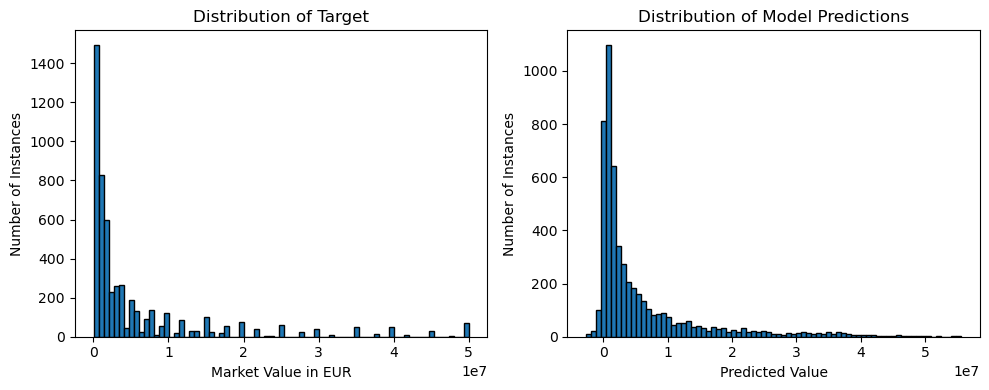

In [189]:
predictions = model.predict(X_val)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].hist(val_df['market_value_in_eur'], bins=75, edgecolor='black')
axs[0].set_title('Distribution of Target')
axs[0].set_xlabel('Market Value in EUR')
axs[0].set_ylabel('Number of Instances')

axs[1].hist(predictions, bins=75, edgecolor='black')
axs[1].set_title('Distribution of Model Predictions')
axs[1].set_xlabel('Predicted Value')
axs[1].set_ylabel('Number of Instances')

plt.tight_layout() 
plt.show()

Learning label

In [190]:
df['log_target'] = np.log(df['market_value_in_eur'])
def determine_label(log_value):
    return int(log_value - 9) - 1

df['label'] = df['log_target'].apply(determine_label)

In [191]:
df = df.dropna()

max_dates = df.groupby('player_id')['val_date'].transform(max)
val_df = df[df['val_date'] == max_dates]
indices_to_drop = val_df.index
train_df = df.drop(indices_to_drop)

X_train = train_df.drop(columns=['market_value_in_eur', 'player_id', 'val_date', 'log_target', 'label'], axis=1)
X_val = val_df.drop(columns=['market_value_in_eur', 'player_id', 'val_date', 'log_target', 'label'], axis=1)
y_train = train_df['label']
y_val = val_df['label']


model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.8,
    depth=10,
    l2_leaf_reg=3,
    border_count=256,
    random_seed=12,
    cat_features=categorical, 
    eval_metric = 'Accuracy'
) 

model.fit(
    X_train, y_train,
    cat_features=categorical,
    eval_set=(X_val, y_val),
    logging_level='Silent',
    plot=True
)

print(f'R2 accuracy score: {round(model.score(X_val, y_val), 2)} \n')

print('Feature importances: \n')
feature_importances = model.get_feature_importance(Pool(X_train, label=y_train, cat_features=categorical))
for i in range(len(feature_importances)):
    print(f'{all_features[i]} : {round(feature_importances[i], 2)}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

R2 accuracy score: 0.64 

Feature importances: 

current_club_id : 14.01
country_of_citizenship : 4.0
sub_position : 0.0
position : 4.57
foot : 8.45
player_club_domestic_competition_id : 5.22
city_of_birth : 4.88
country_of_birth : 3.11
height_in_cm : 1.39
age : 2.3
months_to_contract_end : 7.7
yellow_cards : 7.35
red_cards : 6.61
one : 2.23
goals : 2.97
assists : 2.18
minutes_played : 0.46
num_games : 3.16
percentage_of_substitutions : 1.61
average_attendance : 7.51
player_win_percentage : 3.07
player_national_team_coplayers : 3.61
player_squad_size : 3.6


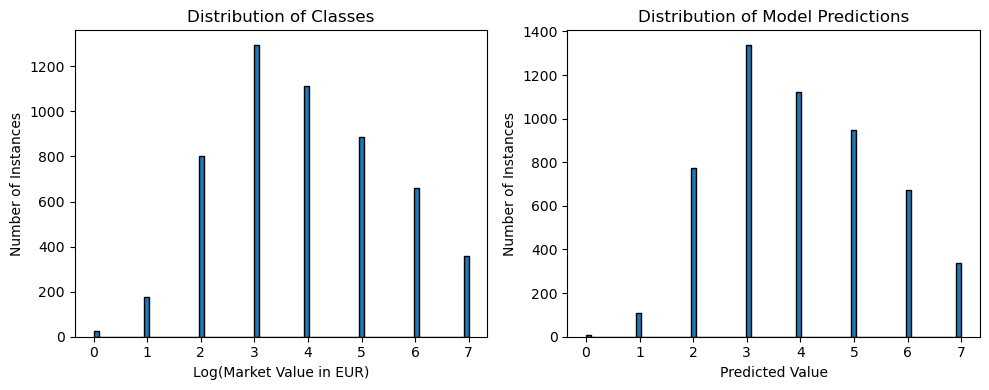

In [192]:
predictions = model.predict(X_val)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].hist(y_val, bins=75, edgecolor='black')
axs[0].set_title('Distribution of Classes')
axs[0].set_xlabel('Log(Market Value in EUR)')
axs[0].set_ylabel('Number of Instances')

axs[1].hist(predictions, bins=75, edgecolor='black')
axs[1].set_title('Distribution of Model Predictions')
axs[1].set_xlabel('Predicted Value')
axs[1].set_ylabel('Number of Instances')

plt.tight_layout() 
plt.show()